In [3]:
import torch
import os
import json
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel

import pysvelte
import analysis_utils
from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

%load_ext autoreload
%autoreload 2

/home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("Model Loading...")
# path = "AlekseyKorshuk/vicuna-7b"
path = "./llama_7b/"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

# base_model = "decapoda-research/llama-7b-hf"
# lora_weights = "tiedong/goat-lora-7b"

# tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer', padding_side='right')
# model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     load_in_8bit=False,
#     torch_dtype=torch.float32,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(
#     model,
#     lora_weights,
#     torch_dtype=torch.float32,
#     device_map={'': 0},
# )

tokenizer.pad_token_id = tokenizer.eos_token_id

Model Loading...


Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]


## Evaluating Models

In [5]:
data_file = "./box_datasets/no_instructions/alternative/Random/3/train.jsonl"
object_file = "./box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 1

In [6]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=100,
    data_file=data_file,
    # object_file=object_file,
    few_shot=False,
    alt_examples=True,
    # num_ents_or_ops=3,
    architecture="LLaMAForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 100


In [7]:
idx = 2
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)
print(f"Answer: {tokenizer.decode(dataset[idx]['labels'])}")

Prompt:  The fig is in Box X, the engine is in Box T, the radio is in Box A. Box A contains the
Answer:  radio


In [22]:
total_count = 0
correct_count = 0
model.eval()
with torch.no_grad():
    for _, inputs in tqdm(enumerate(tqdm(dataloader))):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(model.device)

        outputs = model(input_ids=inputs["input_ids"])

        for bi in range(inputs["labels"].size(0)):
            label = inputs["labels"][bi]
            pred = torch.argmax(outputs.logits[bi][inputs["last_token_indices"][bi]])

            if label == pred:
                correct_count += 1
            # else:
            #     print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
            total_count += 1

del outputs
torch.cuda.empty_cache()

current_acc = round(correct_count / total_count, 2)
print(f"Task accuracy: {current_acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.64it/s]
100it [00:05, 17.65it/s]

Task accuracy: 0.94


## Loading Counterfactual Data

In [134]:
raw_data = box_index_aligner_examples(
    tokenizer,
    num_samples=600,
    data_file="./box_datasets/no_instructions/alternative/Random/3/train.jsonl",
    # object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    few_shot=False,
    alt_examples=True,
    num_ents_or_ops=3,
)
batch_size = 12

In [135]:
base_tokens = raw_data[0][:batch_size]
base_last_token_indices = raw_data[1][:batch_size]
source_tokens = raw_data[2][:batch_size]
source_last_token_indices = raw_data[3][:batch_size]
correct_answer_token = raw_data[4][:batch_size]
incorrect_answer_token = raw_data[6][:batch_size]

base_tokens = torch.tensor(base_tokens).to(device)
source_tokens = torch.tensor(source_tokens).to(device)

In [136]:
for i in range(-6, -1):
    print(tokenizer.decode(raw_data[0][i][: raw_data[1][i] + 1]))
    print(tokenizer.decode(raw_data[2][i][: raw_data[3][i] + 1]))
    print(tokenizer.decode(raw_data[4][i]))
    for incorrect_answer in raw_data[6][i]:
        print(tokenizer.decode(incorrect_answer))
    print()

 The drink is in Box Q, the key is in Box W, the train is in Box C. Box Q contains the
 The train is in Box D, the rose is in Box F, the document is in Box I. Box F contains the
 drink
 key
 train

 The drink is in Box Q, the key is in Box W, the train is in Box C. Box W contains the
 The guitar is in Box X, the pipe is in Box C, the brick is in Box E. Box E contains the
 key
 train
 drink

 The drink is in Box Q, the key is in Box W, the train is in Box C. Box C contains the
 The shell is in Box E, the file is in Box F, the newspaper is in Box L. Box E contains the
 train
 drink
 key

 The cup is in Box E, the string is in Box Y, the glass is in Box F. Box E contains the
 The engine is in Box F, the map is in Box Z, the egg is in Box A. Box Z contains the
 cup
 string
 glass

 The cup is in Box E, the string is in Box Y, the glass is in Box F. Box Y contains the
 The cup is in Box D, the wire is in Box J, the rock is in Box R. Box R contains the
 string
 glass
 cup



## Direct Logit Attribution for Object Fetcher Heads

In [ ]:
hook_points = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]

with torch.no_grad():
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

In [ ]:
batch_size = base_tokens.size(0)
d_head = model.config.hidden_size // model.config.num_attention_heads

direct_logit_attr = torch.zeros(
    model.config.num_attention_heads, model.config.num_attention_heads
).to(device)

with torch.no_grad():
    for layer in tqdm(range(model.config.num_hidden_layers)):
        for head in range(model.config.num_attention_heads):
            hook_point = f"model.layers.{layer}.self_attn.o_proj"
            all_head_out = cache[hook_point].input
            decoder = torch.nn.Sequential(
                model.model.layers[layer].self_attn.o_proj,
                model.model.norm,
                model.lm_head,
            )
            start = head * d_head
            end = (head + 1) * d_head

            for bi in range(batch_size):
                head_output = all_head_out[bi, base_last_token_indices[bi], start:end]
                head_output = torch.concat(
                    (
                        torch.zeros(head * d_head).to(head_output.device),
                        head_output,
                        torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                            head_output.device
                        ),
                    ),
                    dim=0,
                )
                head_unembed = decoder(head_output)
                correct_object = correct_answer_token[bi][base_last_token_indices[bi]]
                incorrect_objects = incorrect_answer_token[bi]
                direct_logit_attr[layer, head] += (
                    head_unembed[correct_object]
                    - head_unembed[incorrect_objects[0]]
                    - head_unembed[incorrect_objects[1]]
                )

            direct_logit_attr[layer, head] /= batch_size

torch.cuda.empty_cache()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:55<00:00,  1.75s/it]


In [ ]:
imshow(
    direct_logit_attr,
    yaxis_title="Layer",
    xaxis_title="Head",
)
# Softmax

In [ ]:
imshow(
    direct_logit_attr,
    yaxis_title="Layer",
    xaxis_title="Head",
)
# Softmax

In [ ]:
object_fetcher_heads = analysis_utils.compute_topk_components(direct_logit_attr, 10, largest=True)
print(object_fetcher_heads)

[[23, 15], [18, 24], [26, 16], [19, 16], [21, 29], [28, 17], [16, 13], [21, 3], [20, 27], [28, 30]]


## Logit Value Vs. Attention Score

### Previous Occurance of Query Box

In [12]:
previous_query_box_attn_scores = defaultdict(list)

for layer in range(model.config.num_hidden_layers):
    attn_scores = analysis_utils.get_attn_scores(model, base_tokens, layer)

    for head in range(model.config.num_attention_heads):
        for bi in range(base_tokens.size(0)):
            query_box_token = base_tokens[bi][base_last_token_indices[bi] - 1]
            query_box_prev_pos = [
                i
                for i, token in enumerate(base_tokens[bi][: base_last_token_indices[bi] - 2])
                if token == query_box_token
            ]

            previous_query_box_attn_scores[(layer, head)].append(
                attn_scores[bi, head, base_last_token_indices[bi] - 1, query_box_prev_pos].item()
            )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 │   │   ]                                                                                   │
│   13 │   │                                                                                       │
│   14 │   │   previous_query_box_attn_scores[(layer, head)].append(                               │
│ ❱ 15 │   │   │   attn_scores[bi, head, base_last_token_indices[bi] - 1, query_box_prev_pos].i    │
│   16 │   │   )                                                                                   │
│   17                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: a Tensor with 0 elements cannot be converted to Scalar

In [76]:
hook_point = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]
with torch.no_grad():
    with TraceDict(
        model,
        hook_point,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

# %%
# Computing the logit value of correct object written by object fetcher heads
previous_box_proj = defaultdict(list)

for layer in tqdm(range(model.config.num_hidden_layers)):
    for head in range(model.config.num_attention_heads):
        hook_point = f"model.layers.{layer}.self_attn.o_proj"

        all_head_out = cache[hook_point].input
        batch_size = base_tokens.size(0)
        d_head = model.config.hidden_size // model.config.num_attention_heads

        decoder = torch.nn.Sequential(
            model.model.layers[layer].self_attn.o_proj,
            model.model.norm,
            # model.lm_head,
        )

        start = head * d_head
        end = (head + 1) * d_head

        for bi in range(batch_size):
            head_output = all_head_out[bi, base_last_token_indices[bi] - 1, start:end]
            head_output = torch.concat(
                (
                    torch.zeros(head * d_head).to(head_output.device),
                    head_output,
                    torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                        head_output.device
                    ),
                ),
                dim=0,
            )
            head_unembed = decoder(head_output)
            query_box_token = base_tokens[bi][base_last_token_indices[bi] - 1]

            previous_box_proj[(layer, head)].append(
                torch.dot(head_unembed, model.lm_head.weight[query_box_token]).item()
            )

100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


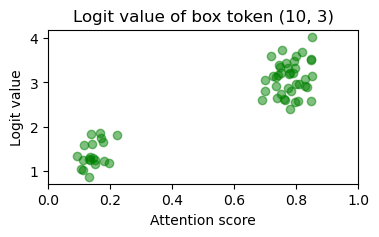

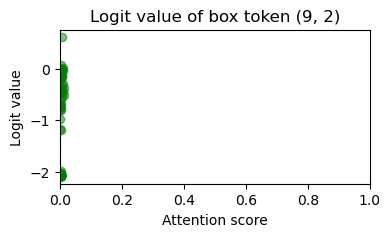

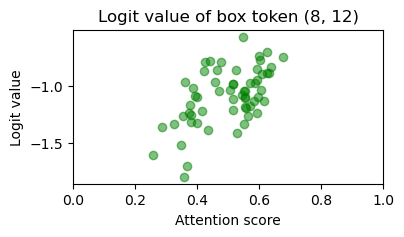

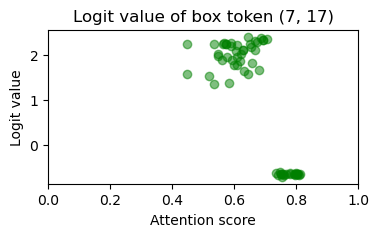

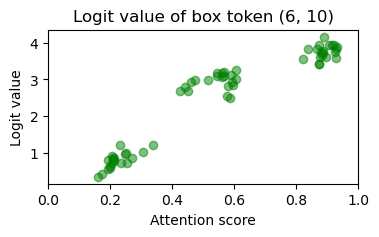

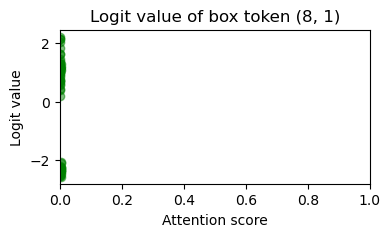

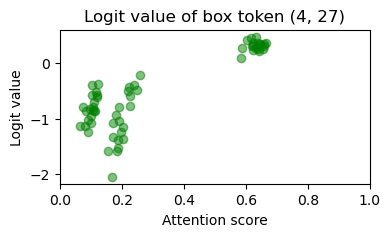

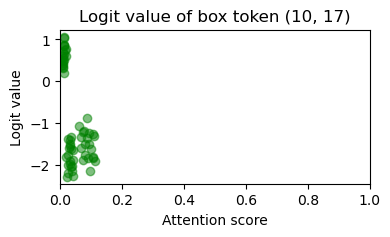

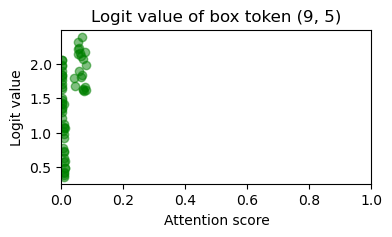

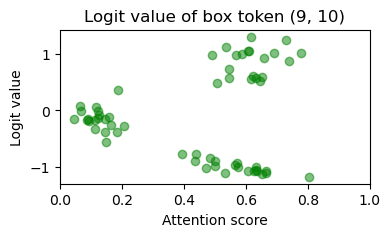

In [79]:
# Create 3 scatter subplots with x-axis as attention scores and y-axis as logit values in the row for each head, one for correct object and two for incorrect objects

for layer, head in previous_box_attender_heads:
    fig, ax = plt.subplots(1, 1, figsize=(4, 2), sharex=True, sharey=True)

    ax.scatter(
        previous_query_box_attn_scores[(layer, head)],
        previous_box_proj[(layer, head)],
        color="green",
        alpha=0.5,
    )

    ax.set_xlabel("Attention score")
    ax.set_ylabel("Logit value")

    ax.set_xlim(0, 1)
    # ax.set_ylim(-1, 10)

    ax.set_title("Logit value of box token ({}, {})".format(layer, head))

    # plt.show()
    plt.savefig(
        os.path.join(
            "result_plots",
            "previous_box_attender_heads",
            "attn_scores_vs_logit_values_{}_{}.png".format(layer, head),
        ),
        dpi=300,
        bbox_inches="tight",
    )

### Query Box

In [11]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    ) + 1
    return prev_query_box_token_pos

In [12]:
query_box_attn_scores = defaultdict(list)

head_attn_scores = torch.zeros(len(heads_at_correct_obj_pos), 2)

for head_idx, (layer, head) in enumerate(heads_at_correct_obj_pos):
    attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for pos in range(2):
        scores = []
        for bi in range(base_tokens.size(0)):
            correct_obj_pos = compute_prev_query_box_pos(
                base_tokens[bi], base_last_token_indices[bi]
            )
            scores.append(
                attn_scores[
                    bi,
                    head,
                    correct_obj_pos,
                    correct_obj_pos - pos,
                ].item()
            )

        if pos == 2:
            query_box_attn_scores[(layer, head)] = scores

        head_attn_scores[head_idx][1 - pos] = np.mean(scores)

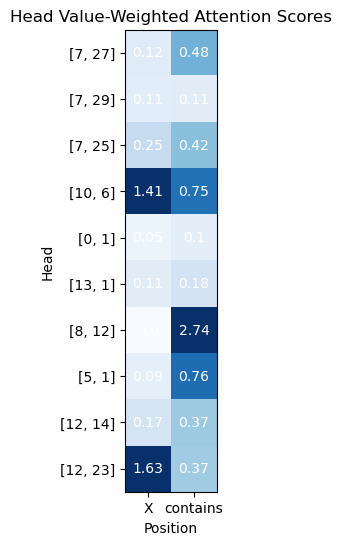

In [12]:
# Plot heatmap of head_attn_scores using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)

ax.imshow(head_attn_scores, cmap="Blues", vmin=0, vmax=1)

# Add text annotations
for i in range(len(heads_at_correct_obj_pos)):
    for j in range(2):
        ax.text(
            j,
            i,
            round(head_attn_scores[i, j].item(), 2),
            ha="center",
            va="center",
            color="w",
        )

ax.set_xlabel("Position")
ax.set_ylabel("Head")

ax.set_xticks([0, 1])
ax.set_xticklabels(["X", "contains"])

ax.set_yticks(range(len(heads_at_correct_obj_pos)))
ax.set_yticklabels(heads_at_correct_obj_pos)

ax.set_title("Head Value-Weighted Attention Scores")

plt.show()

In [86]:
hook_point = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]
with torch.no_grad():
    with TraceDict(
        model,
        hook_point,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

# %%
# Computing the logit value of correct object written by object fetcher heads
query_box_proj = defaultdict(list)

for layer, head in heads_influencing_value_fetcher_heads:
    hook_point = f"model.layers.{layer}.self_attn.o_proj"

    all_head_out = cache[hook_point].input
    batch_size = base_tokens.size(0)
    d_head = model.config.hidden_size // model.config.num_attention_heads

    decoder = torch.nn.Sequential(
        model.model.layers[layer].self_attn.o_proj,
        model.model.norm,
        # model.lm_head,
    )

    start = head * d_head
    end = (head + 1) * d_head

    for bi in range(batch_size):
        head_output = all_head_out[bi, base_last_token_indices[bi], start:end]
        head_output = torch.concat(
            (
                torch.zeros(head * d_head).to(head_output.device),
                head_output,
                torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                    head_output.device
                ),
            ),
            dim=0,
        )
        head_unembed = decoder(head_output)
        query_box_index = base_tokens[bi, base_last_token_indices[bi] - 2]

        query_box_proj[(layer, head)].append(
            torch.dot(head_unembed, model.lm_head.weight[query_box_index]).item()
        )

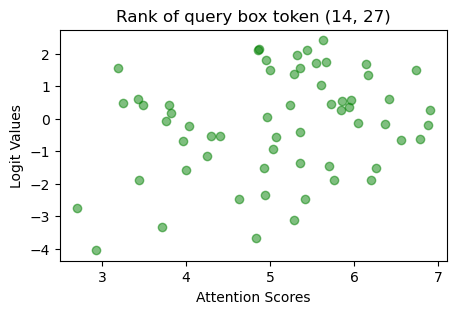

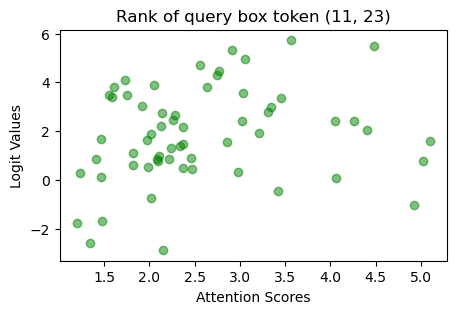

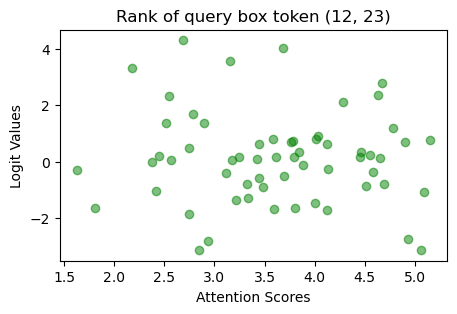

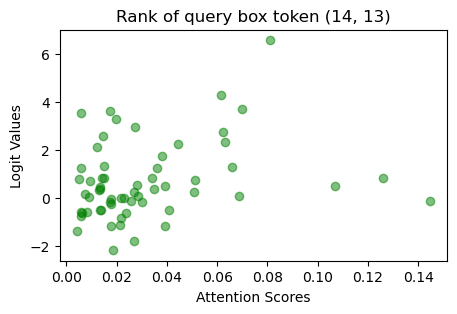

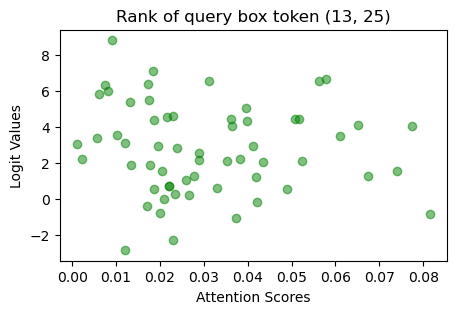

In [87]:
# Create 3 scatter subplots with x-axis as attention scores and y-axis as logit values in the row for each head, one for correct object and two for incorrect objects

for layer, head in heads_influencing_value_fetcher_heads:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True, sharey=True)

    ax.scatter(
        query_box_attn_scores[(layer, head)],
        query_box_proj[(layer, head)],
        color="green",
        alpha=0.5,
    )

    ax.set_xlabel("Attention Scores")
    ax.set_ylabel("Logit Values")

    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, model.config.vocab_size)

    ax.set_title("Rank of query box token ({}, {})".format(layer, head))

    plt.show()
    # plt.savefig(
    #     os.path.join(
    #         "result_plots",
    #         "alternate_format",
    #         "attn_score_vs_projection_query_box_attender_heads",
    #         "attn_scores_vs_logit_values_{}_{}.png".format(layer, head),
    #     ),
    #     dpi=300,
    #     bbox_inches="tight",
    # )

### Correct Object

#### Reverse

In [22]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)

head_attn_score = torch.empty(len(direct_logit_heads), 3)

for head_idx, (layer, head) in enumerate(direct_logit_heads):
    attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 5]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if (token == tokenizer.encode(" is")[-1] and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if (token == tokenizer.encode(" is")[-1] and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if (token == tokenizer.encode(" is")[-1] and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[bi, head, base_last_token_indices[bi], base_last_token_indices[bi]].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

    head_attn_score[head_idx] = torch.tensor(
        [
            np.mean(correct_object_attn_scores[(layer, head)]),
            np.mean(incorrect_object_1_attn_scores[(layer, head)]),
            np.mean(incorrect_object_2_attn_scores[(layer, head)]),
        ]
    )

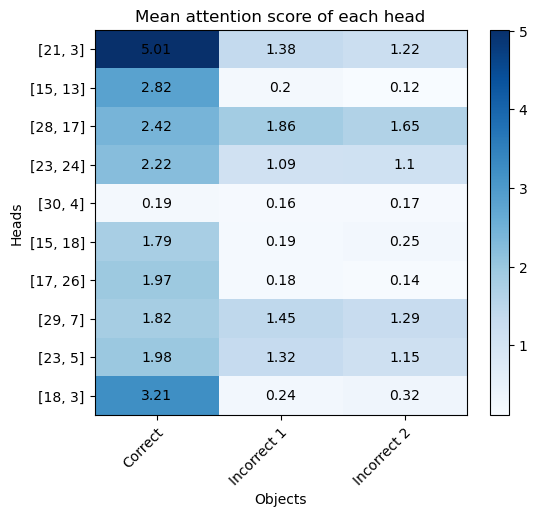

In [23]:
# Plot a heatmap of head_attn_score using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(head_attn_score, cmap="Blues", aspect="auto")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Annotate heatmap with string values
for i in range(3):
    for j in range(len(direct_logit_heads)):
        text = ax.text(
            i,
            j,
            round(head_attn_score[j, i].item(), 2),
            ha="center",
            va="center",
        )

ax.set_title("Mean attention score of each head")
ax.set_xlabel("Objects")
ax.set_ylabel("Heads")

# We want to show all ticks...
ax.set_yticks(np.arange(len(direct_logit_heads)))
ax.set_xticks(np.arange(3))
# ... and label them with the respective list entries
ax.set_yticklabels(direct_logit_heads)
ax.set_xticklabels(["Correct", "Incorrect 1", "Incorrect 2"])

# Rotate the tick labels and set their alignment.
plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)

plt.show()

In [24]:
filtered_direct_logits_heads = [[21, 3], [15, 13], [23, 24], [15, 18], [17, 26], [18, 3]]

In [25]:
hook_point = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]
with torch.no_grad():
    with TraceDict(
        model,
        hook_point,
        retain_input=True,
    ) as cache:
        _ = model(base_tokens)

# %%
# Computing the logit value of correct object written by object fetcher heads
correct_object_proj = defaultdict(list)
incorrect_object_1_proj = defaultdict(list)
incorrect_object_2_proj = defaultdict(list)

for layer, head in filtered_direct_logits_heads:
    hook_point = f"model.layers.{layer}.self_attn.o_proj"

    all_head_out = cache[hook_point].input
    batch_size = base_tokens.size(0)
    d_head = model.config.hidden_size // model.config.num_attention_heads

    decoder = torch.nn.Sequential(
        model.model.layers[layer].self_attn.o_proj,
        model.model.norm,
        # model.lm_head,
    )

    start = head * d_head
    end = (head + 1) * d_head

    with torch.no_grad():
        for bi in range(batch_size):
            head_output = all_head_out[bi, base_last_token_indices[bi], start:end]
            head_output = torch.concat(
                (
                    torch.zeros(head * d_head).to(head_output.device),
                    head_output,
                    torch.zeros((model.config.num_attention_heads - head - 1) * d_head).to(
                        head_output.device
                    ),
                ),
                dim=0,
            )
            head_unembed = decoder(head_output)
            correct_object = correct_answer_token[bi]
            correct_object_proj[(layer, head)].append(
                torch.dot(head_unembed, model.lm_head.weight[correct_object]).item()
            )
            incorrect_object_1_proj[(layer, head)].append(
                torch.dot(head_unembed, model.lm_head.weight[incorrect_answer_token[bi][0]]).item()
            )
            incorrect_object_2_proj[(layer, head)].append(
                torch.dot(head_unembed, model.lm_head.weight[incorrect_answer_token[bi][1]]).item()
            )

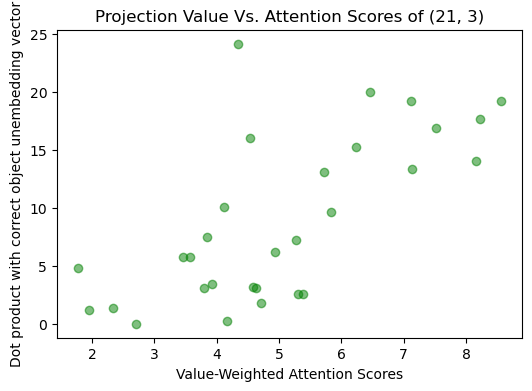

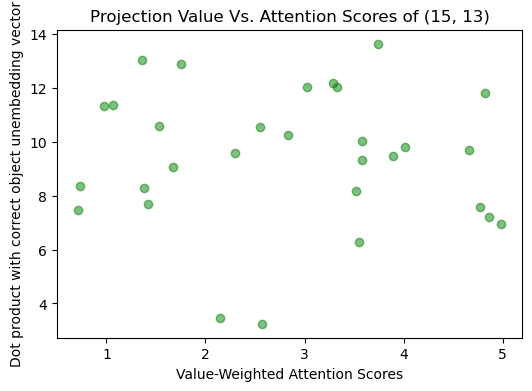

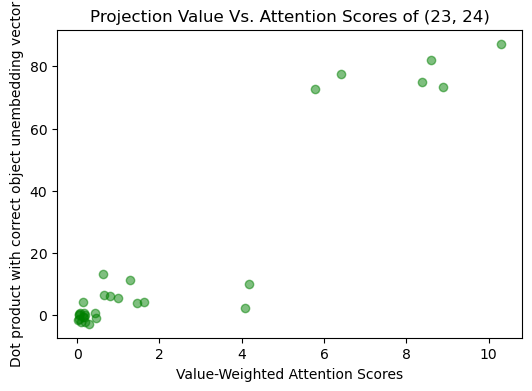

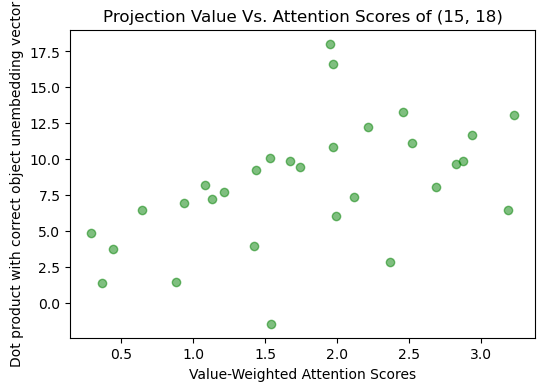

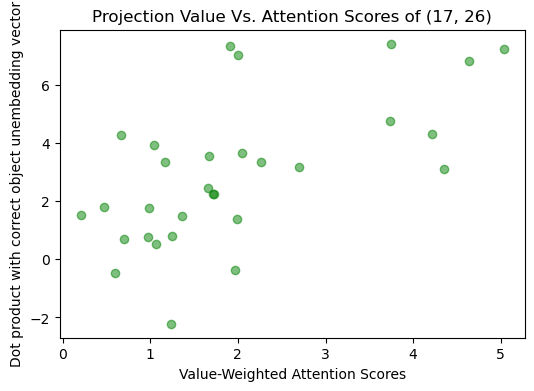

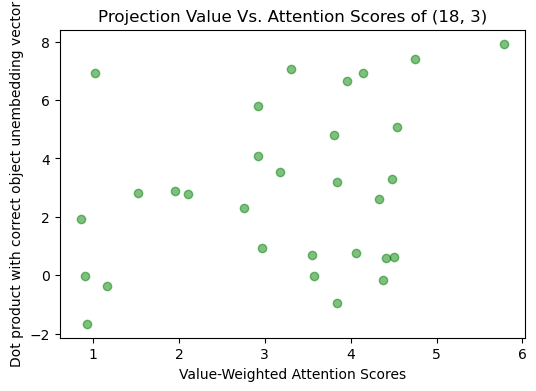

In [29]:
for layer, head in filtered_direct_logits_heads:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)

    ax.scatter(
        correct_object_attn_scores[(layer, head)],
        correct_object_proj[(layer, head)],
        color="green",
        alpha=0.5,
    )

    ax.set_xlabel("Value-Weighted Attention Scores")
    ax.set_ylabel("Dot product with correct object unembedding vector")

    # ax.set_xlim(0, 1)

    ax.set_title(f"Projection Value Vs. Attention Scores of {layer, head}")

    # plt.savefig("combined_attn_vs_logit.png", dpi=300, bbox_inches="tight")
    plt.savefig(
        os.path.join(
            "result_plots",
            "alternate_format",
            "logit_vs_attn",
            "{}_{}.png".format(layer, head),
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

#### Forward

In [18]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)

head_attn_score = torch.empty(len(direct_logit_heads), 3)

for head_idx, (layer, head) in enumerate(direct_logit_heads):
    attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 3]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[bi, head, base_last_token_indices[bi], base_last_token_indices[bi]].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

        head_attn_score[head_idx] = torch.tensor(
            [
                np.mean(correct_object_attn_scores[(layer, head)]),
                np.mean(incorrect_object_1_attn_scores[(layer, head)]),
                np.mean(incorrect_object_2_attn_scores[(layer, head)]),
            ]
        )

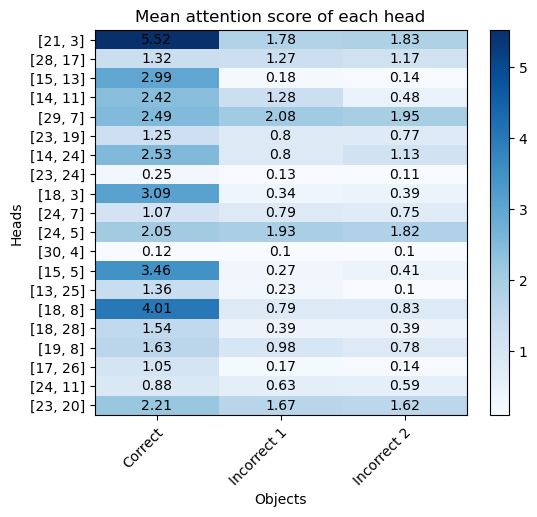

In [19]:
# Plot a heatmap of head_attn_score using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(head_attn_score, cmap="Blues", aspect="auto")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Annotate heatmap with string values
for i in range(3):
    for j in range(len(direct_logit_heads)):
        text = ax.text(
            i,
            j,
            round(head_attn_score[j, i].item(), 2),
            ha="center",
            va="center",
        )

ax.set_title("Mean attention score of each head")
ax.set_xlabel("Objects")
ax.set_ylabel("Heads")

# We want to show all ticks...
ax.set_yticks(np.arange(len(direct_logit_heads)))
ax.set_xticks(np.arange(3))
# ... and label them with the respective list entries
ax.set_yticklabels(direct_logit_heads)
ax.set_xticklabels(["Correct", "Incorrect 1", "Incorrect 2"])

# Rotate the tick labels and set their alignment.
plt.setp(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)

plt.show()

In [20]:
filtered_direct_logit_heads = [
    [21, 3],
    [15, 13],
    [14, 11],
    [14, 24],
    [18, 3],
    [15, 5],
    [18, 8],
    [18, 28],
    [17, 26],
]

## Implementing Path Patching

In [21]:
hook_points = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]

# hook_points += [f"model.layers.{layer}.mlp" for layer in range(model.config.num_hidden_layers)]

with torch.no_grad():
    # Step 1
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as clean_cache:
        _ = model(base_tokens)

    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as corrupt_cache:
        _ = model(source_tokens)

In [55]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    )
    return prev_query_box_token_pos

In [68]:
def patching_heads(
    inputs,
    output,
    layer,
    sender_layer,
    sender_head,
    clean_last_token_indices,
    corrupt_last_token_indices,
    rel_pos,
):
    """
    rel_pos: Represents the token position relative to the "real" (non-padded) last token in the sequence. All the heads at this position and subsequent positions need to patched from clean run, except the sender head at this position.
    """

    input = inputs[0]
    batch_size = input.size(0)

    if "o_proj" in layer:
        input = rearrange(
            input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        clean_head_outputs = rearrange(
            clean_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        corrupt_head_outputs = rearrange(
            corrupt_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )

        layer = int(layer.split(".")[2])
        if sender_layer == layer:
            for bi in range(batch_size):
                if rel_pos == -1:
                    # Computing the previous query box label token position
                    clean_prev_box_label_pos = compute_prev_query_box_pos(
                        base_tokens[bi], clean_last_token_indices[bi]
                    )
                    corrupt_prev_box_label_pos = compute_prev_query_box_pos(
                        source_tokens[bi], corrupt_last_token_indices[bi]
                    )
                else:
                    clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos
                    corrupt_prev_box_label_pos = corrupt_last_token_indices[bi] - rel_pos

                print(tokenizer.decode(base_tokens[bi][clean_prev_box_label_pos]))

                for pos in range(clean_prev_box_label_pos, clean_last_token_indices[bi] + 1):
                    for head_ind in range(model.config.num_attention_heads):
                        if head_ind == sender_head and pos == clean_prev_box_label_pos:
                            input[bi, pos, sender_head] = corrupt_head_outputs[
                                bi, corrupt_prev_box_label_pos, sender_head
                            ]
                        else:
                            input[bi, pos, head_ind] = clean_head_outputs[bi, pos, head_ind]

        else:
            for bi in range(batch_size):
                if rel_pos == -1:
                    # Computing the previous query box label token position
                    clean_prev_box_label_pos = compute_prev_query_box_pos(
                        base_tokens[bi], clean_last_token_indices[bi]
                    )
                else:
                    clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos

                print(tokenizer.decode(base_tokens[bi][clean_prev_box_label_pos]))

                for pos in range(clean_prev_box_label_pos, clean_last_token_indices[bi] + 1):
                    input[bi, pos] = clean_head_outputs[bi, pos]

        input = rearrange(
            input,
            "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
            n_heads=model.config.num_attention_heads,
        )

        w_o = model.model.layers[layer].self_attn.o_proj.weight
        output = einsum(
            input,
            w_o,
            "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
        )

    return output

In [69]:
def patching_receiver_heads(
    output, layer, patched_cache, receiver_heads, clean_last_token_indices, rel_pos
):
    batch_size = output.size(0)
    receiver_heads_in_curr_layer = [h for l, h in receiver_heads if l == int(layer.split(".")[2])]

    output = rearrange(
        output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    patched_head_outputs = rearrange(
        patched_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    # Patch in the output of the receiver heads from patched run
    for receiver_head in receiver_heads_in_curr_layer:
        for bi in range(batch_size):
            if rel_pos == -1:
                # Computing the previous query box label token position
                clean_prev_box_label_pos = compute_prev_query_box_pos(
                    base_tokens[bi], clean_last_token_indices[bi]
                )
            else:
                clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos

            output[bi, clean_prev_box_label_pos, receiver_head] = patched_head_outputs[
                bi, clean_prev_box_label_pos, receiver_head
            ]

    output = rearrange(
        output,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )

    return output

In [70]:
receiver_heads = [[11, 23]]

receiver_layers = list(
    set([f"model.layers.{layer}.self_attn.v_proj" for layer, _ in receiver_heads])
)

# receiver_heads = [[layer, head] for layer, head in [[21, 3]]]

print(receiver_layers)
print(receiver_heads)

['model.layers.11.self_attn.v_proj']
[[11, 23]]


In [71]:
path_patching_logits = torch.zeros(
    model.config.num_hidden_layers, model.config.num_attention_heads
).to(device)
batch_size = base_tokens.size(0)
apply_softmax = torch.nn.Softmax(dim=-1)

for layer in tqdm(range(model.config.num_hidden_layers)):
    for head in range(model.config.num_attention_heads):
        with torch.no_grad():
            # Step 2
            with TraceDict(
                model,
                hook_points + receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_heads,
                    sender_layer=layer,
                    sender_head=head,
                    clean_last_token_indices=base_last_token_indices,
                    corrupt_last_token_indices=source_last_token_indices,
                    rel_pos=2,
                ),
            ) as patched_cache:
                _ = model(base_tokens)

            # Step 3
            with TraceDict(
                model,
                receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_receiver_heads,
                    patched_cache=patched_cache,
                    receiver_heads=receiver_heads,
                    clean_last_token_indices=base_last_token_indices,
                    rel_pos=0,
                ),
            ) as _:
                patched_out = model(base_tokens)

            for bi in range(batch_size):
                logits = apply_softmax(patched_out.logits[bi, base_last_token_indices[bi]])
                path_patching_logits[layer, head] += (logits[correct_answer_token[bi]]).item()

            path_patching_logits[layer, head] = path_patching_logits[layer, head] / batch_size

del patched_out
torch.cuda.empty_cache()

  0%|          | 0/32 [00:00<?, ?it/s]

 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 

  3%|▎         | 1/32 [00:12<06:23, 12.38s/it]

 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 

  3%|▎         | 1/32 [00:21<11:18, 21.88s/it]

 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D
 U
 X
 T
 A
 V
 D


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:24                                                                                   │
│                                                                                                  │
│   21 │   │   │   │   │   rel_pos=2,                                                              │
│   22 │   │   │   │   ),                                                                          │
│   23 │   │   │   ) as patched_cache:                                                             │
│ ❱ 24 │   │   │   │   _ = model(base_tokens)                                                      │
│   25 │   │   │                                                                                   │
│   26 │   │   │   # Step 3                                                                        │
│   27 │   │   │   with TraceDict(                                                                 │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/transformers/models/llama/mode │
│ ling_llama.py:765 in forward                                                                     │
│                                                                                                  │
│   762 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return   │
│   763 │   │                                                                                      │
│   764 │   │   # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)    │
│ ❱ 765 │   │   outputs = self.model(                                                              │
│   766 │   │   │   input_ids=input_ids,                                                           │
│   767 │   │   │   attention_mask=attention_mask,                                                 │
│   768 │   │   │   past_key_values=past_key_values,                                               │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)    

In [61]:
imshow(
    (path_patching_logits - torch.mean(path_patching_logits)) / torch.std(path_patching_logits),
    title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_box_pos = analysis_utils.compute_topk_components(path_patching_logits, k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_at_box_pos}")

Head influencing object info fetcher heads: [[0, 1], [0, 0], [0, 2], [0, 4], [0, 3]]


## Circuit Analysis

### Alternative

In [138]:
original_logits = 0
apply_softmax = torch.nn.Softmax(dim=-1)

with torch.no_grad():
    output = model(base_tokens)
    for bi in range(base_tokens.size(0)):
        logits = apply_softmax(output.logits[bi, base_last_token_indices[bi]])
        original_logits += (logits[correct_answer_token[bi]]).item()

    original_logits = original_logits / batch_size

del output
torch.cuda.empty_cache()

In [106]:
path = "./new_pp_exps/reverse/direct_logit_heads_new.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads influencing final logit",
    yaxis_title="Layer",
    xaxis_title="Head",
)

direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=20, largest=False)
print(f"Head influencing final logit: {direct_logit_heads}")

Head influencing final logit: [[21, 3], [15, 13], [28, 17], [23, 24], [30, 4], [15, 18], [17, 26], [29, 7], [23, 5], [18, 3], [23, 15], [22, 21], [17, 28], [19, 30], [23, 20], [24, 5], [18, 8], [24, 29], [18, 28], [13, 25]]


In [97]:
patching_values = torch.load("./new_pp_exps/reverse/heads_affecting_direct_logit_heads_new.pt")

imshow(
    (patching_values - original_logits) / original_logits,
    title="Heads affecting query vector of value fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_value_fetcher_heads = analysis_utils.compute_topk_components(
    patching_values, 5, largest=False
)

print(heads_influencing_value_fetcher_heads)

[[14, 27], [11, 23], [12, 23], [14, 13], [13, 25]]


In [141]:
patching_values = torch.load("/home/local_nikhil/Projects/Anima-2.0/new_pp_exps/reverse/heads_v_comp_at_query_box_token_pos.pt")

imshow(
    (patching_values - original_logits) / original_logits,
    title="Heads affecting query vector of value fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_value_fetcher_heads = analysis_utils.compute_topk_components(
    patching_values, 15, largest=False
)

print(heads_influencing_value_fetcher_heads)

[[13, 14], [10, 3], [9, 10], [11, 23], [9, 2], [9, 7], [9, 21], [11, 24], [13, 0], [13, 25], [13, 9], [8, 12], [12, 0], [7, 17], [12, 23]]


### Original

In [7]:
original_logits = 0
apply_softmax = torch.nn.Softmax(dim=-1)

with torch.no_grad():
    output = model(base_tokens)
    for bi in range(base_tokens.size(0)):
        logits = apply_softmax(output.logits[bi, base_last_token_indices[bi]])
        original_logits += (logits[correct_answer_token[bi]]).item()

    original_logits = original_logits / batch_size

del output
torch.cuda.empty_cache()

In [15]:
path = "./new_pp_exps/forward/direct_logit_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads influencing final logit",
    yaxis_title="Layer",
    xaxis_title="Head",
)

direct_logit_heads = analysis_utils.compute_topk_components(logit_values, k=20, largest=False)
print(f"Head influencing final logit: {direct_logit_heads}")

Head influencing final logit: [[21, 3], [28, 17], [15, 13], [14, 11], [29, 7], [23, 19], [14, 24], [23, 24], [18, 3], [24, 7], [24, 5], [30, 4], [15, 5], [13, 25], [18, 8], [18, 28], [19, 8], [17, 26], [24, 11], [23, 20]]


In [129]:
path = "./new_pp_exps/forward/heads_q_comp_with_direct_logit_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting query vector of object fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_object_value_fetcher_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing object info fetcher heads: {heads_influencing_object_value_fetcher_heads}")

Head influencing object info fetcher heads: [[14, 27], [11, 23], [12, 23], [13, 25], [13, 1], [15, 13], [19, 12], [9, 0], [16, 2], [10, 6]]


In [10]:
path = "./new_pp_exps/forward/heads_k_comp_with_object_fetcher_at_correct_pos_new.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting key vector of object value fetcher heads at correct token position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_correct_obj_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=5, largest=False
)
print(
    f"Head in K-composition with value fetcher heads at correct token position: {heads_at_correct_obj_pos}"
)

Head in K-composition with value fetcher heads at correct token position: [[8, 21], [16, 22], [14, 0], [11, 11], [11, 26]]


In [9]:
path = "./new_pp_exps/forward/heads_v_comp_at_contains_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    # title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_contains_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing object info fetcher heads: {heads_at_contains_pos}")

Head influencing object info fetcher heads: [[7, 27], [7, 29], [7, 25], [10, 6], [0, 1], [13, 1], [8, 12], [5, 1], [12, 14], [12, 23]]


In [17]:
path = "./new_pp_exps/forward/heads_v_comp_with_11_23_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_at_box_pos}")

Head influencing object info fetcher heads: [[10, 3], [9, 2], [9, 10], [9, 21], [8, 12]]


In [18]:
path = "./new_pp_exps/forward/heads_v_comp_12_23_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (12, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_v_comp_12_23 = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_v_comp_12_23}")

Head influencing object info fetcher heads: [[10, 3], [10, 17], [11, 24], [9, 7], [9, 21]]


In [19]:
path = "./new_pp_exps/forward/heads_v_comp_with_14_27_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (14, 27) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_v_comp_14_27 = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_v_comp_14_27}")

Head influencing object info fetcher heads: [[13, 25], [10, 3], [13, 14], [11, 23], [9, 10]]


## Verifying Positional Information

### Loading Data

In [145]:
value_exps = object_alignment_example_sampler(
    tokenizer,
    num_samples=180,
    data_file="./box_datasets/no_instructions/original/3/train.jsonl",
    object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    num_ents_or_ops=3,
    few_shot=False,
    alt_examples=False,
)

org_tokens = value_exps[2]
org_last_token_indices = value_exps[3]
alt_tokens = value_exps[0]
alt_last_token_indices = value_exps[1]
correct_answer_token = value_exps[4]

org_tokens = torch.tensor(org_tokens).to(device)
alt_tokens = torch.tensor(alt_tokens).to(device)
correct_answer_token = torch.tensor(correct_answer_token).to(device)

In [153]:
positional_exps = shift_query_position_example_sampler(
    tokenizer,
    num_samples=180,
    data_file="./box_datasets/no_instructions/original/3/train.jsonl",
    object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    num_ents_or_ops=3,
    few_shot=False,
    alt_examples=False,
)

org_tokens = positional_exps[0]
org_last_token_indices = positional_exps[1]
alt_tokens = positional_exps[2]
alt_last_token_indices = positional_exps[3]
correct_answer_token = positional_exps[4]

org_tokens = torch.tensor(org_tokens).to(device)
alt_tokens = torch.tensor(alt_tokens).to(device)
correct_answer_token = torch.tensor(correct_answer_token).to(device)

In [154]:
for i in range(0, 5):
    print(tokenizer.decode(org_tokens[i][: org_last_token_indices[i] + 1]))
    print(tokenizer.decode(alt_tokens[i][: alt_last_token_indices[i] + 1]))
    print(tokenizer.decode(correct_answer_token[i]))
    print()

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 0 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 0 contains
 boot

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 1 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 1 contains
 l

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 2 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 2 contains
 bell

 Box 0 contains stone, Box 1 contains cherimoya, Box 2 contains otamatone. Box 0 contains
 Box 1 contains cherimoya, Box 2 contains otamatone, Box 0 contains stone. Box 0 contains
 stone

 Box 0 contains stone, Box 1 contains cherimoya, Box 2 contains otamatone. Box 1 contains
 Box 1 contains cherimoya, Box 2 contains otamatone, Box 0 contains stone. Box 1 contains
 cher



### Activation Patching

In [155]:
# value_fetcher_heads = [[layer, head] for layer, head in heads_influencing_final_logit if layer > 15]
# value_fetcher_heads

In [156]:
heads_influencing_object_value_fetcher_heads

[[12, 20], [14, 11], [15, 13], [13, 25], [14, 27]]

In [157]:
hook_points = []
for l, h in heads_influencing_object_value_fetcher_heads:
    hook_points.append(f"model.layers.{l}.self_attn.o_proj")

hook_points = list(set(hook_points))

In [158]:
answer_logits = torch.zeros(org_tokens.size(0))
with torch.no_grad():
    output = model(org_tokens)
    logits = output.logits
    for bi in range(org_tokens.size(0)):
        answer_logits[bi] = logits[bi, org_last_token_indices[bi], correct_answer_token[bi]].item()

del output, logits
torch.cuda.empty_cache()

In [159]:
with torch.no_grad():
    with TraceDict(model, hook_points, retain_input=True) as alt_cache:
        _ = model(alt_tokens)

In [160]:
def activation_patching(
    inputs, output, layer, patching_heads, cache, input_last_pos, patch_last_pos
):
    input = inputs[0]

    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    patch = rearrange(
        cache[layer].input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    layer_index = int(layer.split(".")[2])
    heads = [h for l, h in patching_heads if l == layer_index]

    for bi in range(input.size(0)):
        for head in heads:
            input[bi, input_last_pos[bi], head] = patch[bi, patch_last_pos[bi], head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )

    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input,
        w_o,
        "batch seq_len d_model, hidden_size d_model -> batch seq_len d_model",
    )

    return output

In [161]:
with torch.no_grad():
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
        edit_output=partial(
            activation_patching,
            patching_heads=heads_influencing_object_value_fetcher_heads,
            cache=alt_cache,
            input_last_pos=org_last_token_indices,
            patch_last_pos=alt_last_token_indices,
        ),
    ) as _:
        output = model(org_tokens)

    patched_answer_logits = torch.zeros(org_tokens.size(0))
    for bi in range(org_tokens.size(0)):
        logits = output.logits[bi, org_last_token_indices[bi]]
        patched_answer_logits[bi] = logits[correct_answer_token[bi]].item()

    print(
        f"Decrease in the answer logits: {round((patched_answer_logits - answer_logits).mean().item(), 2)}"
    )

del logits, output
torch.cuda.empty_cache()

Decrease in the answer logits: -2.1


In [336]:
del output, logits
torch.cuda.empty_cache()

## Visualizing Head Attention

In [ ]:
# [[14, 27], [11, 23], [12, 23], [14, 13], [13, 25], [13, 14], [14, 0], [13, 0], [19, 12], [15, 13]]

In [91]:
layer = 13
attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)

In [92]:
value_vectors_norm = torch.norm(value_vectors, dim=-1)
scaled_attn = einsum(
    value_vectors_norm,
    attn_scores,
    "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
)

In [95]:
index = 2
print(f"layer: {layer}, Bi: {index}")
pysvelte.AttentionMulti(
    tokens=[tokenizer.decode(token) for token in base_tokens[index].cpu().tolist()],
    attention=scaled_attn[index].permute(1, 2, 0).cpu(),
).show()

layer: 13, Bi: 2


## Ablation Experiments

### Ablating Correct Object Locator Heads in the Forward Setting

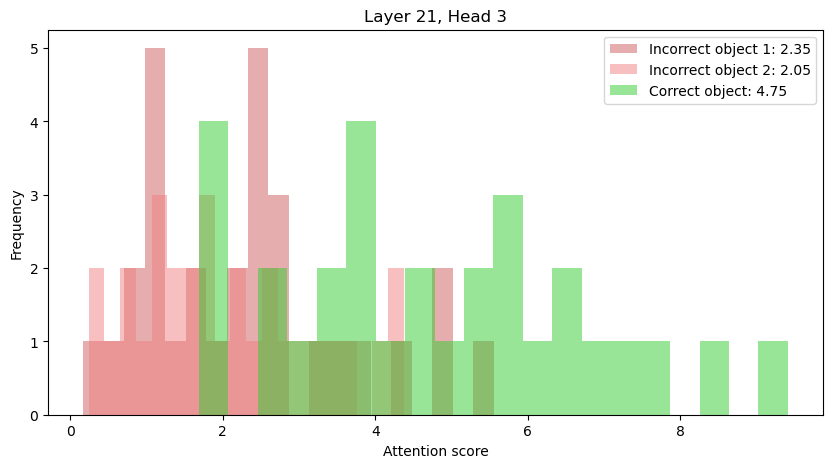

In [14]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)
ablation_heads = [[14, 27], [11, 23], [12, 23]]

for layer, head in direct_logit_heads:
    attn_scores, value_vectors = analysis_utils.get_attn_scores(
        model,
        base_tokens,
        layer,
        ablation_heads=ablation_heads,
        last_token_pos=base_last_token_indices,
    )
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 3]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[bi, head, base_last_token_indices[bi], base_last_token_indices[bi]].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

    # Plotting
    plt.figure(figsize=(10, 5))
    # plt.hist(self_attn_scores[(layer, head)], bins=20, alpha=0.5, label=f"Self: {round(np.mean(self_attn_scores[(layer, head)]), 2)}", color="red")
    plt.hist(
        incorrect_object_1_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 1: {round(np.mean(incorrect_object_1_attn_scores[(layer, head)]), 2)}",
        color="indianred",
    )
    plt.hist(
        incorrect_object_2_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 2: {round(np.mean(incorrect_object_2_attn_scores[(layer, head)]), 2)}",
        color="lightcoral",
    )
    plt.hist(
        correct_object_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Correct object: {round(np.mean(correct_object_attn_scores[(layer, head)]), 2)}",
        color="limegreen",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Attention score")
    # plt.xlim([0, 1])
    plt.title(f"Layer {layer}, Head {head}")
    plt.legend()

    #     plt.savefig(
    #         os.path.join(
    #             "result_plots",
    #             "alternate_format",
    #             "attn_score_of_logit_heads",
    #             "attn_scores_{}_{}.png".format(layer, head),
    #         ),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )
    plt.show()

### Activation Patching on Object Attender Heads

In [117]:
base_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the"
base_tokens = tokenizer(base_prompt, return_tensors="pt").input_ids.to(device)
last_base_token_pos = (
    tokenizer(base_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)
source_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the"
source_tokens = tokenizer.encode(source_prompt, return_tensors="pt").to(device)
last_source_token_pos = (
    tokenizer(source_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)

In [118]:
ablation_heads = heads_influencing_object_value_fetcher_heads
modules = list(set([f"model.layers.{layer}.self_attn.o_proj" for layer, _ in ablation_heads]))

In [119]:
with torch.no_grad():
    with TraceDict(model, modules, retain_input=True) as source_cache:
        _ = model(source_tokens)

In [132]:
def patch_head_output(
    inputs=None, output=None, layer=None, heads=None, base_last=None, source_last=None
):
    input = inputs[0]
    # print(input.shape)
    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    cache = rearrange(
        source_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    heads_at_curr_layer = [h for l, h in heads if l == int(layer.split(".")[2])]
    # print(heads_at_curr_layer, layer)

    for head in heads_at_curr_layer:
        input[0, base_last, head] = cache[0, source_last, head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    )

    return output

In [133]:
with torch.no_grad():
    with TraceDict(
        model,
        modules,
        retain_input=True,
        edit_output=partial(
            patch_head_output,
            heads=ablation_heads,
            base_last=last_base_token_pos,
            source_last=last_source_token_pos,
        ),
    ) as _:
        output = model(base_tokens)

In [134]:
logit, pred = torch.max(output.logits[0, -1], dim=-1)
print(f"{base_prompt}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")
print(f"{source_prompt}")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the: ' glass', 14.51
Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the


In [70]:
output = model(source_tokens)
pred = torch.argmax(output.logits[0, -1], dim=-1).item()
print(f"{source_prompt}: '{tokenizer.decode(pred)}'")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the: ' lady'


### Patching Residual Stream

In [170]:
original = "Box B contains the fig, Box C contains the engine, Box A contains the photo. Box A contains the"
original_tokens = tokenizer.encode(original, return_tensors="pt").to(device)
alternative = "Box A contains the apple, Box B contains the orange, Box C contains the banana. Box B contains the"
alternative_tokens = tokenizer.encode(alternative, return_tensors="pt").to(device)

modules = [f"model.layers.{layer}" for layer in range(32)]

In [28]:
original = "The fig is in Box X, the engine is in Box T, the radio is in Box A. Box S contains the"
original_tokens = tokenizer.encode(original, return_tensors="pt").to(device)
alternative = "The cup is in Box J, Box G fell on the ground, the wire is in Box M. Box G contains the"
alternative_tokens = tokenizer.encode(alternative, return_tensors="pt").to(device)

modules = [f"model.layers.{layer}" for layer in range(32)]

In [29]:
with TraceDict(model, modules) as cache:
    _ = model(alternative_tokens)

In [32]:
def patch_residual(output, layer):
    residual = cache[layer].output
    output[0][:, -1] = residual[0][:, -1]

    return output

In [33]:
for layer in range(32):
    with TraceDict(model, [f"model.layers.{layer}"], edit_output=patch_residual) as _:
        output = model(original_tokens)
    logit, pred = torch.max(output.logits[0, -1], dim=-1)
    print(f"Layer: {layer}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")

Layer: 0: ' battery', 12.61
Layer: 1: ' battery', 12.61
Layer: 2: ' battery', 12.61
Layer: 3: ' battery', 12.63
Layer: 4: ' battery', 12.63
Layer: 5: ' battery', 12.57
Layer: 6: ' battery', 12.58
Layer: 7: ' battery', 12.59
Layer: 8: ' battery', 12.72
Layer: 9: ' battery', 12.82
Layer: 10: ' battery', 12.69
Layer: 11: ' tools', 12.87
Layer: 12: ' tools', 12.81
Layer: 13: ' tools', 12.65
Layer: 14: ' engine', 12.84
Layer: 15: ' engine', 12.9
Layer: 16: ' engine', 12.88
Layer: 17: ' engine', 12.78
Layer: 18: ' battery', 12.06
Layer: 19: ' engine', 12.2
Layer: 20: ' wire', 12.28
Layer: 21: ' wire', 12.14
Layer: 22: ' wire', 12.01
Layer: 23: ' wire', 12.88
Layer: 24: ' wire', 12.66
Layer: 25: ' wire', 12.54
Layer: 26: ' wire', 12.44
Layer: 27: ' wire', 12.43
Layer: 28: ' wire', 12.36
Layer: 29: ' wire', 12.22
Layer: 30: ' wire', 12.27
Layer: 31: ' wire', 12.39


The engine is in Box S, the machine is in Box L, the brain is in Box I. Box I contains the: ' brain', 12.91


## Attention Knockout

In [9]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [10]:
def intervention_wrapper(batch_size, seq_len, from_pos, to_pos):
    def attention_knockout(inputs, output, layer):
        if "norm" in layer:
            return output
        global queries, keys, attn_outputs
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        d_head = d_model // n_heads
        layer_index = int(layer.split(".")[2])

        if "q_proj" in layer:
            query = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            queries[layer_index] = query

        elif "k_proj" in layer:
            key = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            keys[layer_index] = key

        elif "v_proj" in layer:
            value = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            key = keys[layer_index]
            query = queries[layer_index]

            kv_seq_len = key.shape[-2]
            cos, sin = model.model.layers[layer_index].self_attn.rotary_emb(
                value, seq_len=kv_seq_len
            )
            positions = [i for i in range(seq_len)]
            positions = torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
            query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

            attn_scores = einsum(
                key,
                query,
                "batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos",
            )
            attn_scores = attn_scores / math.sqrt(d_head)
            attn_scores = apply_causal_mask(attn_scores, layer, from_pos, to_pos)
            attn_scores = torch.softmax(attn_scores, dim=-1)
            attn_output = einsum(
                attn_scores,
                value,
                "batch n_heads query_pos key_pos, batch n_heads key_pos d_head -> batch query_pos n_heads d_head",
            )
            attn_output = attn_output.reshape(batch_size, seq_len, d_model)
            attn_outputs[layer_index] = attn_output

        elif "o_proj" in layer:
            attn_output = attn_outputs[layer_index]
            o_proj_weight = model.model.layers[layer_index].self_attn.o_proj.weight
            output = einsum(
                attn_output,
                o_proj_weight,
                "batch seq_len d_model, hidden_size d_model -> batch seq_len hidden_size",
            )
            return output
        else:
            return output

    return attention_knockout

In [11]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    ) + 3
    return prev_query_box_token_pos

In [12]:
def compute_segments(inputs, correct_object_pos):
    segs = []
    segments = defaultdict(list)

    seg_end_pos = torch.cat([inputs.eq(29892).nonzero()[:, 1], inputs.eq(29889).nonzero()[:, 1]])
    for seg_idx in range(seg_end_pos.size(0)):
        segs.append(
            torch.arange(seg_end_pos[seg_idx - 1] + 1 if seg_idx > 0 else 1, seg_end_pos[seg_idx] + 1)
        )
    for seg in segs:
        if correct_object_pos in seg:
            segments["correct_obj"] = seg
        else:
            if "incorrect_obj_1" not in segments:
                segments["incorrect_obj_1"] = seg
            else:
                segments["incorrect_obj_2"] = seg

    return segments

In [13]:

def apply_causal_mask(attn_scores, layer, from_pos, to_pos):
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()
    attn_scores.masked_fill_(mask, ignore)
    
    # Attention knockout
    # layer_index = int(layer.split('.')[2])
    for pos in from_pos:
        attn_scores[:, :, pos, to_pos] = ignore

    return attn_scores

In [23]:
accuracies = defaultdict(float)
comma_token = 29892
period_token = 29889
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
            [f"model.layers.{i}.self_attn.k_proj",
            f"model.layers.{i}.self_attn.q_proj", 
            f"model.layers.{i}.self_attn.v_proj",
            f"model.layers.{i}.self_attn.o_proj"] 
            for i in range(knockout_layer, model.config.num_hidden_layers)
        ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, inputs in tqdm(enumerate(tqdm(dataloader)), desc=f"{knockout_layer}"):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to(model.device)

            batch_size, seq_len = inputs["input_ids"].shape
            from_pos = [pos for pos in range(inputs["last_token_indices"]-3, inputs["last_token_indices"]+1)]
            # print(tokenizer.decode(inputs["input_ids"][0][inputs["last_token_indices"]-4]), from_pos)

            with TraceDict(
                model, 
                modules, 
                retain_output=True,
                edit_output=intervention_wrapper(batch_size, 
                                                    seq_len, 
                                                    from_pos=from_pos, 
                                                    to_pos=inputs["last_token_indices"]-4)) as _:
                outputs = model(input_ids=inputs["input_ids"])

            for bi in range(inputs["labels"].size(0)):
                label = inputs["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][inputs["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer]}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.83it/s]
0: 100it [00:11,  8.83it/s]


Knockout Starting Layer 0 acc: 0.87


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]
1: 100it [00:11,  8.93it/s]


Knockout Starting Layer 1 acc: 0.87


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]
2: 100it [00:11,  9.08it/s]


Knockout Starting Layer 2 acc: 0.9


100%|██████████| 100/100 [00:10<00:00,  9.18it/s]
3: 100it [00:10,  9.18it/s]


Knockout Starting Layer 3 acc: 0.91


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]
4: 100it [00:11,  9.03it/s]


Knockout Starting Layer 4 acc: 0.93


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]
5: 100it [00:10,  9.14it/s]


Knockout Starting Layer 5 acc: 0.94


6: 53it [00:05,  9.25it/s]0:05<00:05,  9.27it/s]
 53%|█████▎    | 53/100 [00:05<00:05,  9.25it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:28                                                                                   │
│                                                                                                  │
│   25 │   │   │   from_pos = [pos for pos in range(inputs["last_token_indices"]-3, inputs["las    │
│   26 │   │   │   # print(tokenizer.decode(inputs["input_ids"][0][inputs["last_token_indices"]    │
│   27 │   │   │                                                                                   │
│ ❱ 28 │   │   │   with TraceDict(                                                                 │
│   29 │   │   │   │   model,                                                                      │
│   30 │   │   │   │   modules,                                                                    │
│   31 │   │   │   │   retain_output=True,                                                         │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/baukit/nethook.py:164 in       │
│ __init__                                                                                         │
│                                                                                                  │
│   161 │   │   │   │   │   return obj.get(layer, None)                                            │
│   162 │   │   │   │   return obj                                                                 │
│   163 │   │   │                                                                                  │
│ ❱ 164 │   │   │   self[layer] = Trace(                                                           │
│   165 │   │   │   │   module=module,                                                             │
│   166 │   │   │   │   layer=layer,                                                               │
│   167 │   │   │   │   retain_output=optional_dict(retain_output),                                │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/baukit/nethook.py:69 in        │
│ __init__                                                                                         │
│                                                                                                  │
│    66 │   │   retainer = self                                                                    │
│    67 │   │   self.layer = layer                                                                 │
│    68 │   │   if layer is not None:                                                              │
│ ❱  69 │   │   │   module = get_module(module, layer)                                             │
│    70 │   │                                                                                      │
│    71 │   │   def retain_hook(m, inputs, output):                                                │
│    72 │   │   │   if edit_output:                                                                │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/baukit/nethook.py:365 in       │
│ get_module                                                                                       │
│                                                                                                  │
│   362 │   """                                                                                    │
│   363 │   Finds the named module within the given model.                                         │
│   364 │   """                                                                                    │
│ ❱ 365 │   for n, m in model.named_modules():               

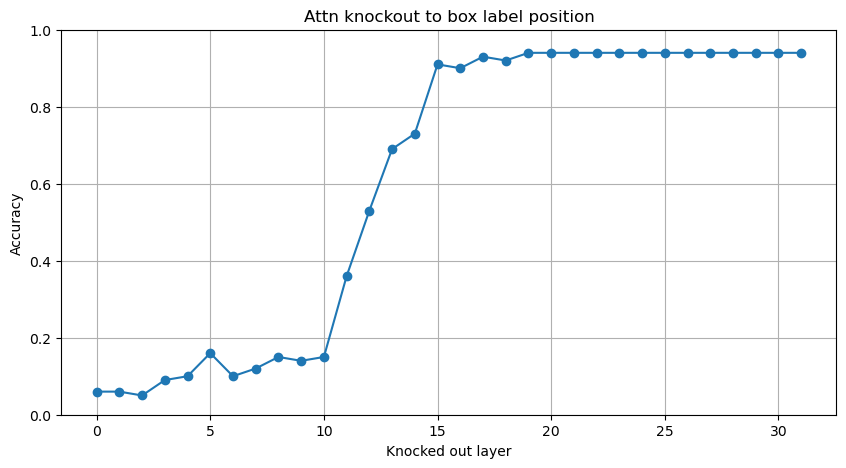

In [17]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker="o")
plt.xlabel("Knocked out layer")
plt.ylabel("Accuracy")
plt.title("Attn knockout to box label position")
plt.ylim([0, 1])
plt.grid()
plt.show()

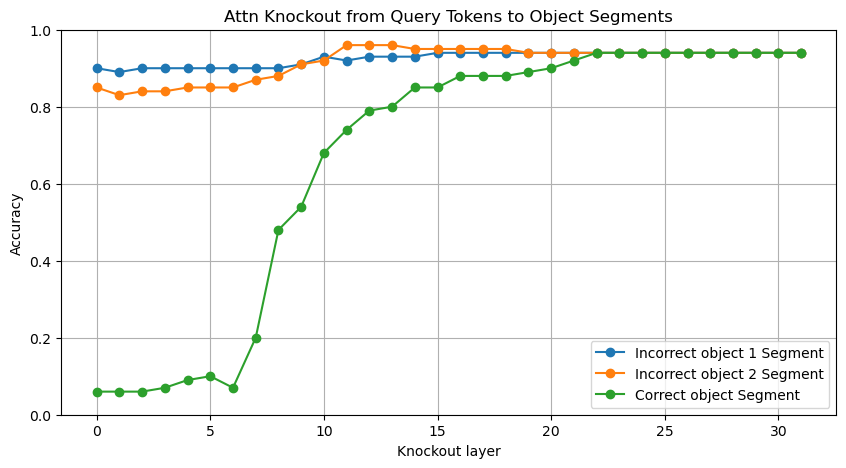

In [42]:

# plot accuracies for each knockout layer
plt.figure(figsize=(10, 5))
plt.plot(list(accuracies.keys()), [acc[1] for acc in accuracies.values()], label="Incorrect object 1 Segment", marker="o")
plt.plot(list(accuracies.keys()), [acc[2] for acc in accuracies.values()], label="Incorrect object 2 Segment", marker="o")
plt.plot(list(accuracies.keys()), [acc[0] for acc in accuracies.values()], label="Correct object Segment", marker="o")
plt.title("Attn Knockout from Query Tokens to Object Segments")
plt.xlabel("Knockout layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

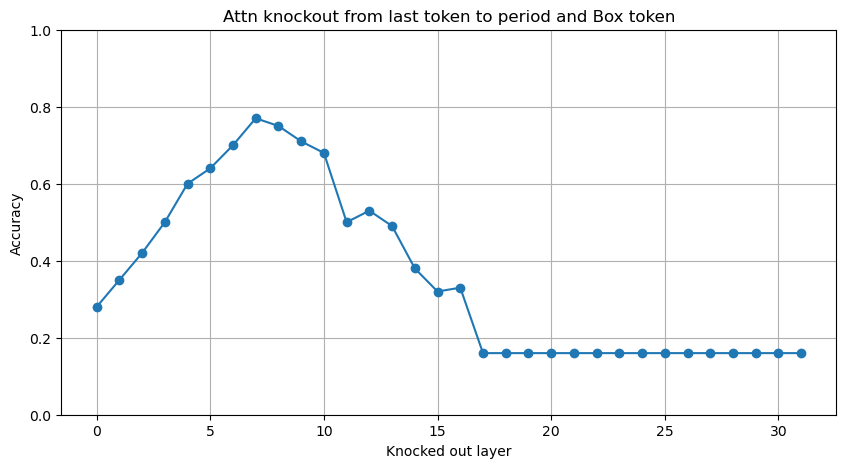

Text(0.5, 1.0, 'Attn Knockout from Query Tokens to Correct Object Segment')

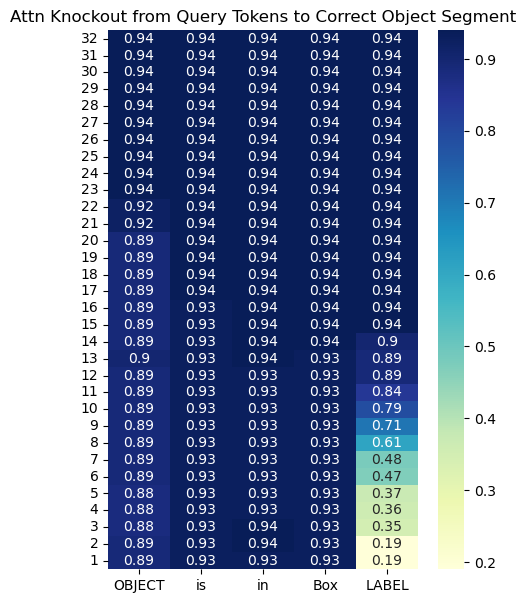

In [47]:
# Plot a heatmap of accuracies
accuracies_list = np.array(list(accuracies.values()))
accuracies_list = np.flip(accuracies_list, axis=0)

plt.figure(figsize=(5, 7))
sns.heatmap(
    accuracies_list,
    annot=True,
    cmap="YlGnBu",
    yticklabels=[i for i in range(32, 0, -1)],
    xticklabels=["OBJECT", "is", "in", "Box", "LABEL"],
)
plt.title("Attn Knockout from Query Tokens to Correct Object Segment")

 18%|█▊        | 18/100 [00:01<00:05, 14.61it/s]

100%|██████████| 100/100 [00:06<00:00, 14.56it/s]
100it [00:06, 14.56it/s]

Task accuracy: 0.99
